In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import plot_confusion_matrix, roc_curve, RocCurveDisplay

In [ ]:
!pip install ipynb

In [ ]:
%cd "/content/drive/My Drive/CS539/proj/"

In [ ]:
from ipynb.fs.full.func import *
"""
read_MS(f)
subset_by_mz (df, feat)
logistic_regression(df_feat, label)
scale_intensities(df_feat)
risk_score(df_feat, b)
normalize_0_1(r)
retrieve_location (f, col)
fit_calc_score(f, feature, label)
"""

Wiki page: https://en.wikipedia.org/wiki/Mass_spectrometry_imaging <br>
'After collecting a mass spectrum at one spot, the sample is moved to reach another region, and so on, until the entire sample is scanned. By choosing a peak in the resulting spectra that corresponds to the compound of interest, the MS data is used to map its distribution across the sample.'

In [ ]:
# example mass spectrum of pixel (1,1) from 'Normal' sample '1999-129BN-NEG.csv'
df = pd.read_csv('/content/drive/My Drive/CS539/proj/data/NEG/Normal/1999-129BN-NEG.csv')
plt.plot(df['Unnamed: 0'], df['V1'])
plt.xlabel('m/z')
plt.ylabel('Intensity')

In [ ]:
# m/z values for all samples are the same, tot 367
mz = df['Unnamed: 0']
print(mz)

In [ ]:
# example read_MS from 'Normal' sample '1999-129BN-NEG.csv'
l = read_MS('/content/drive/My Drive/CS539/proj/data/NEG/Normal/1999-129BN-NEG.csv')
l

'The tumor samples appear to exhibit higher ion abundances in the mass range of m/z 650–850 in positive mode and m/z 250–350 in negative mode, which are typically associated with phospholipids (PLs) and long-chain fatty acids (FAs), respectively. The normal samples were found to contain more larger lipids in the mass range of m/z 850–1000 in positive mode, e.g., triglyceride TG (54:4) with NH4+ adduct at m/z 900.8030.' Tu et al. (2021)  https://doi.org/10.1007/s11306-021-01819-x <br>
Mass spectra obtained in positive/negative mode appear to be different. Hence POS/NEG datasets will be trained and testes separately.

### Postive mode data

In [ ]:
# Normal
path = "/content/drive/My Drive/CS539/proj/data/POS/Normal/"
dir_list = os.listdir(path)
pos_normal = pd.DataFrame()
for f in dir_list:
  df = read_MS('/content/drive/My Drive/CS539/proj/data/POS/Normal/'+ f)
  pos_normal = pos_normal.append(df)

# Tumor
path = "/content/drive/My Drive/CS539/proj/data/POS/Tumor/"
dir_list = os.listdir(path)
pos_tumor = pd.DataFrame()
for f in dir_list:
  df = read_MS('/content/drive/My Drive/CS539/proj/data/POS/Tumor/'+ f)
  pos_tumor = pos_tumor.append(df)

In [ ]:
# tot 26825
# tumor 12840
# normal 13985
pos_data = pd.concat((pos_tumor,pos_normal), ignore_index=True)
pos_label = np.concatenate((np.repeat(1, pos_tumor.shape[0]), np.repeat(-1, pos_normal.shape[0])))

### Negative mode data

In [ ]:
# Normal
path = "/content/drive/My Drive/CS539/proj/data/NEG/Normal/"
dir_list = os.listdir(path)
neg_normal = pd.DataFrame()
for f in dir_list:
  df = read_MS('/content/drive/My Drive/CS539/proj/data/NEG/Normal/'+ f)
  neg_normal = neg_normal.append(df)

# Tumor
path = "/content/drive/My Drive/CS539/proj/data/NEG/Tumor/"
dir_list = os.listdir(path)
neg_tumor = pd.DataFrame()
for f in dir_list:
  df = read_MS('/content/drive/My Drive/CS539/proj/data/NEG/Tumor/'+ f)
  neg_tumor = neg_tumor.append(df)

In [ ]:
# tot 30326
# tumor 15340
# normal 14986
neg_data = pd.concat((neg_tumor,neg_normal), ignore_index=True)
neg_label = np.concatenate((np.repeat(1, neg_tumor.shape[0]), np.repeat(-1, neg_normal.shape[0])))

### Partition the data into training and testing (7:3 split)

In [ ]:
np.random.seed(10)

In [ ]:
from sklearn.model_selection import train_test_split
X_train_pos, X_test_pos, y_train_pos, y_test_pos = train_test_split(pos_data, pos_label, test_size=0.30, stratify = pos_label, random_state=np.random.seed(10))
X_train_neg, X_test_neg, y_train_neg, y_test_neg = train_test_split(neg_data, neg_label, test_size=0.30, stratify = neg_label, random_state=np.random.seed(10))

## Random forest
### Train the random classifier and test the trained model

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
# tune hyperparameters n_estimators and max_features
# param_grid = {'n_estimators': 10**np.arange(3), 
#              'max_features': ['auto','sqrt','log2']}
# gs_rf = GridSearchCV(RandomForestClassifier(), param_grid=param_grid)
# gs_rf.fit(X_train_pos, y_train_pos)

In [ ]:
# print('POS:',gs_rf.best_params_)
# POS: {'max_features': 'sqrt', 'n_estimators': 100}

In [ ]:
# gs_rf.fit(X_train_neg, y_train_neg)

In [ ]:
# print('NEG:',gs_rf.best_params_)
# NEG: {'max_features': 'auto', 'n_estimators': 100}

In [ ]:
# Random Forest
# POS
rf_pos = RandomForestClassifier(n_estimators=100, max_features='sqrt', random_state=np.random.seed(10))
rf_pos.fit(X_train_pos, y_train_pos)
rf_pos_y_pred = rf_pos.predict(X_test_pos)   

In [ ]:
# NEG
rf_neg = RandomForestClassifier(n_estimators=100, max_features='auto', random_state=np.random.seed(10))
rf_neg.fit(X_train_neg, y_train_neg)
rf_neg_y_pred = rf_neg.predict(X_test_neg)  

### Analyze the results

Positive mode

In [ ]:
plot_confusion_matrix(rf_pos, X_test_pos, y_test_pos)  
plt.show()
# 4148 48
# 73 3779

In [ ]:
rf_pos_acc = rf_pos.score(X_test_pos,y_test_pos)
print("Accuracy: " + str(rf_pos_acc*100) + '%')
# Accuracy: 98.4965208747515%

In [ ]:
rf_pos_fpr, rf_pos_tpr, _ = roc_curve(y_test_pos, rf_pos_y_pred)
roc_display = RocCurveDisplay(fpr = rf_pos_fpr, tpr = rf_pos_tpr).plot()

Negative mode

In [ ]:
plot_confusion_matrix(rf_neg, X_test_neg, y_test_neg)  
plt.show()
# 4431 65
# 123 4479

In [ ]:
rf_neg_acc = rf_neg.score(X_test_neg,y_test_neg)
print("Accuracy: " + str(rf_neg_acc*100) + '%')
# Accuracy: 97.93361178280941%

In [ ]:
rf_neg_fpr, rf_neg_tpr, _ = roc_curve(y_test_neg, rf_neg_y_pred)
roc_display = RocCurveDisplay(fpr = rf_neg_fpr, tpr = rf_neg_tpr).plot()

### Select the 50 most important features by random forest for further analysis

In [ ]:
# rf top 50 features selection
# POS
rf_pos_idx = np.argsort(rf_pos.feature_importances_)[-50:]
pos_column_names = list(pos_data.columns.values)
rf_pos_feature = []
for i in rf_pos_idx:
  rf_pos_feature.append(pos_column_names[i])
print('POS:',rf_pos_feature)

# NEG
rf_neg_idx = np.argsort(rf_neg.feature_importances_)[-50:]
neg_column_names = list(neg_data.columns.values)
rf_neg_feature = []
for i in rf_neg_idx:
  rf_neg_feature.append(neg_column_names[i])
print('NEG:',rf_neg_feature)

## Support vector machine
### Train the SVM and test the trained model

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.svm import LinearSVC

In [ ]:
# pipeline=make_pipeline(StandardScaler(), LinearSVC())
# param_grid = {'linearsvc__C': 10.**np.arange(-3,3)}
# svm_gs = GridSearchCV(pipeline, param_grid=param_grid)

In [ ]:
# POS
# svm_gs.fit(X_train_pos, y_train_pos)

In [ ]:
# print('POS:',svm_gs.best_params_)
# POS: {'linearsvc__C': 0.01}

In [ ]:
# NEG
# svm_gs.fit(X_train_neg, y_train_neg)

In [ ]:
# print('NEG:',svm_gs.best_params_)
# NEG: {'linearsvc__C': 0.1}

In [ ]:
# POS
svm_pos = LinearSVC(C=0.01,random_state=np.random.seed(10))
svm_pos.fit(X_train_pos, y_train_pos)
svm_pos_y_pred = svm_pos.predict(X_test_pos) 

In [ ]:
# NEG
svm_neg = LinearSVC(C=0.1,random_state=np.random.seed(10))
svm_neg.fit(X_train_neg, y_train_neg)
svm_neg_y_pred = svm_neg.predict(X_test_neg) 

### Analyze the results

Positive mode

In [ ]:
plot_confusion_matrix(svm_pos, X_test_pos, y_test_pos)  
plt.show()
# 4112 84
# 44 3808

In [ ]:
svm_pos_acc = svm_pos.score(X_test_pos,y_test_pos)
print("Accuracy: " + str(svm_pos_acc*100) + '%')
# Accuracy: 98.40954274353876%

In [ ]:
svm_pos_fpr, svm_pos_tpr, _ = roc_curve(y_test_pos, svm_pos_y_pred)
roc_display = RocCurveDisplay(fpr = svm_pos_fpr, tpr = svm_pos_tpr).plot()

Negative mode

In [ ]:
plot_confusion_matrix(svm_neg, X_test_neg, y_test_neg)  
plt.show()
# 4308 188
# 64 4538

In [ ]:
svm_neg_acc = svm_neg.score(X_test_neg,y_test_neg)
print("Accuracy: " + str(svm_neg_acc*100) + '%')
# Accuracy: 97.23016047482963%

In [ ]:
svm_neg_fpr, svm_neg_tpr, _ = roc_curve(y_test_neg, svm_neg_y_pred)
roc_display = RocCurveDisplay(fpr = svm_neg_fpr, tpr = svm_neg_tpr).plot()

### Select the 50 most important features by SVM for further analysis

In [ ]:
# POS
svm_pos_idx = (svm_pos.coef_[0]).argsort()[:50]
pos_column_names = list(pos_data.columns.values)
pos_svm_feature = []
for i in svm_pos_idx:
  pos_svm_feature.append(pos_column_names[i])
print('POS:',pos_svm_feature)

# NEG
svm_neg_idx = (svm_neg.coef_[0]).argsort()[:50]
neg_column_names = list(neg_data.columns.values)
neg_svm_feature = []
for i in svm_neg_idx:
  neg_svm_feature.append(neg_column_names[i])
print('NEG:',neg_svm_feature)

## Select common features from RF and SVM

In [ ]:
pos_feat = np.intersect1d(rf_pos_feature, pos_svm_feature)
neg_feat = np.intersect1d(rf_neg_feature, neg_svm_feature)
print('POS:',pos_feat)
print('NEG:',neg_feat)

In [ ]:
from matplotlib_venn import venn2
venn2(subsets = (50-len(pos_feat), 50-len(pos_feat), len(pos_feat)), set_labels = ('Random Forest', 'SVM'))
print('Positive mode')
plt.show()

In [ ]:
venn2(subsets = (50-len(neg_feat), 50-len(neg_feat), len(neg_feat)), set_labels = ('Random Forest', 'SVM'))
print('Negative mode')
plt.show()

In [ ]:
# subset the combined dataset based on the selected features
pos_subset = subset_by_mz(pos_data,pos_feat)
neg_subset = subset_by_mz(neg_data,neg_feat)

In [ ]:
b_pos = logistic_regression(pos_subset,pos_label)
b_neg = logistic_regression(neg_subset,neg_label)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  FutureWarning,


In [ ]:
# original
N_pos = fit_calc_score('/content/drive/My Drive/CS539/proj/data/POS/Normal/202012122000-75_N_POS.csv', pos_feat, b_pos,'N')

In [ ]:
T_pos = fit_calc_score('/content/drive/My Drive/CS539/proj/data/POS/Tumor/20201212_2000-75T_POS.csv', pos_feat, b_pos,'T')

In [ ]:
N_pos = fit_calc_score('/content/drive/My Drive/CS539/proj/data/POS/Normal/20201213-2003-192N-POS.csv', pos_feat, b_pos,'N')

In [ ]:
T_pos = fit_calc_score('/content/drive/My Drive/CS539/proj/data/POS/Tumor/20201213-2003-192T-POS.csv', pos_feat, b_pos,'T')

In [ ]:
N_neg = fit_calc_score('/content/drive/My Drive/CS539/proj/data/NEG/Normal/20201213-2003-192N-NEG.csv', neg_feat, b_neg,'N')

In [ ]:
T_neg = fit_calc_score('/content/drive/My Drive/CS539/proj/data/NEG/Tumor/20201213-2003-192T_NEG.csv', neg_feat, b_neg,'T')

In [ ]:
N_pos.to_csv('/content/drive/My Drive/CS539/proj/data/N_pos.csv')
T_pos.to_csv('/content/drive/My Drive/CS539/proj/data/T_pos.csv')

In [ ]:
%load_ext rpy2.ipython

In [ ]:
%%R
install.packages('gridExtra')

In [ ]:
%%R
library(ggplot2)
library(gridExtra)
library(dplyr)

R[write to console]: 
Attaching package: ‘dplyr’


R[write to console]: The following object is masked from ‘package:gridExtra’:

    combine


R[write to console]: The following objects are masked from ‘package:stats’:

    filter, lag


R[write to console]: The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [ ]:
%%R -i N_pos
N_pos

     x  y         sc
0    1  1 0.15519646
1    2  1 0.34644637
2    3  1 0.37298125
3    4  1 0.38644808
4    5  1 0.40376000
5    6  1 0.37429804
6    7  1 0.35035647
7    8  1 0.30235425
8    9  1 0.35405906
9   10  1 0.18605525
10  11  1 0.29502459
11  12  1 0.39225093
12  13  1 0.40856024
13  14  1 0.43363087
14  15  1 0.36925311
15  16  1 0.32885583
16  17  1 0.36089352
17  18  1 0.40293353
18  19  1 0.40430267
19  20  1 0.41273341
20  21  1 0.16850494
21  22  1 0.36833084
22  23  1 0.38508824
23  24  1 0.35764683
24  25  1 0.40168525
25  26  1 0.35949298
26  27  1 0.36568862
27  28  1 0.43820350
28  29  1 0.36160782
29  30  1 0.32081968
30  31  1 0.28030239
31  32  1 0.49032476
32  33  1 0.35853952
33  34  1 0.47003278
34  35  1 0.50052793
35  36  1 0.46835346
36  37  1 0.51558024
37  38  1 0.43954559
38  39  1 0.44568066
39  40  1 0.45215211
40  41  1 0.50332556
41  42  1 0.45023163
42  43  1 0.43565543
43  44  1 0.41262534
44  45  1 0.62571057
45  46  1 0.26133756
46  47  1 0.2

In [ ]:
%%R -i N_neg
N_neg

In [ ]:
%%R -i T_pos
T_pos

      x  y          sc
0     1  1 0.233304682
1     2  1 0.180439560
2     3  1 0.095561895
3     4  1 0.362410398
4     5  1 0.185377953
5     6  1 0.345717021
6     7  1 0.267088947
7     8  1 0.203846115
8     9  1 0.321051072
9    10  1 0.044660033
10   11  1 0.073939952
11   12  1 0.120352711
12   13  1 0.300337301
13   14  1 0.125257341
14   15  1 0.006802855
15   16  1 0.204423210
16   17  1 0.264321528
17   18  1 0.162341229
18   19  1 0.210456467
19   20  1 0.333916808
20   21  1 0.313190797
21   22  1 0.135559922
22   23  1 0.171022020
23   24  1 0.102286136
24   25  1 0.215851616
25   26  1 0.126342860
26   27  1 0.137137725
27   28  1 0.288310735
28    1  2 0.256851625
29    2  2 0.342536961
30    3  2 0.358887013
31    4  2 0.391575901
32    5  2 0.295949457
33    6  2 0.276302438
34    7  2 0.203882017
35    8  2 0.269616563
36    9  2 0.250953585
37   10  2 0.272958089
38   11  2 0.427721518
39   12  2 0.204967725
40   13  2 0.357084158
41   14  2 0.256077016
42   15  2 

In [ ]:
%%R -i T_neg
T_neg

In [ ]:
%%R
N_pos$sc[N_pos$sc > 0.6] = 0.6
T_pos$sc[T_pos$sc > 0.6] = 0.6

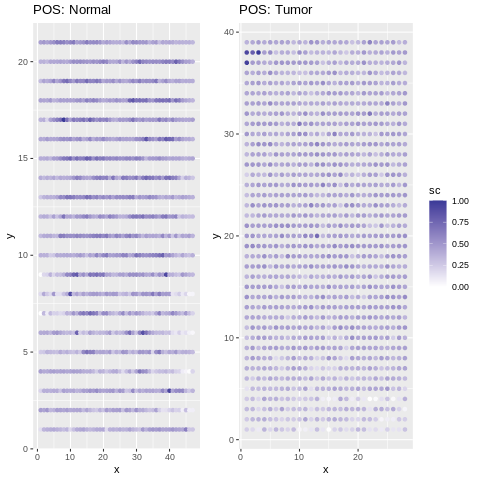

In [ ]:
%%R
p1 <- ggplot(N_pos, aes(x=x, y=y)) + geom_point(aes(color=sc)) + 
  scale_colour_gradient2() + 
  theme(legend.position="none") + ggtitle('POS: Normal')
p2 <- ggplot(T_pos, aes(x=x, y=y)) + geom_point(aes(color=sc)) + 
  scale_colour_gradient2() + ggtitle('POS: Tumor')
grid.arrange(p1, p2, ncol=2, widths=c(1.5,2))

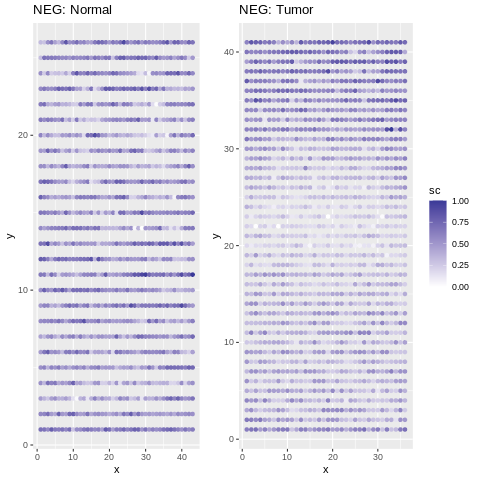

In [ ]:
%%R
p1 <- ggplot(N_neg, aes(x=x, y=y)) + geom_point(aes(color=sc)) + 
  scale_colour_gradient2() + 
  theme(legend.position="none") + ggtitle('NEG: Normal')
p2 <- ggplot(T_neg, aes(x=x, y=y)) + geom_point(aes(color=sc)) + 
  scale_colour_gradient2() + ggtitle('NEG: Tumor')
grid.arrange(p1, p2, ncol=2, widths=c(1.5,2))

After scaling, Normal vs. Tumor risk score heatmaps in positive/negative mode are plotted, where sc represents the relative risk of having tumor. Evidently, the tumor sample is being more risky than the normal one. To further improve the differentiation performance, region of interest (ROI) can be determined when pre-processing the data. However, this requires assistance from professionals.

In [ ]:
%%R
p1 <- ggplot(N_pos, aes(x=x, y=y)) + geom_point(aes(color=sc)) + 
  scale_colour_gradientn(colours = terrain.colors(10)) + 
  theme(legend.position="none") + ggtitle('POS: Normal')
p2 <- ggplot(T_pos, aes(x=x, y=y)) + geom_point(aes(color=sc)) + 
  scale_colour_gradientn(colours = terrain.colors(10)) + ggtitle('POS: Tumor')
grid.arrange(p1, p2, ncol=2, widths=c(1.5,2))

UsageError: Cell magic `%%R` not found.
